In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tda.nn import TDA, TDAClip


In [2]:
import torch.optim as optim
import pandas as pd
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Load and preprocess the dataset
data_path = 'household_power_consumption.txt'
data = pd.read_csv(data_path, sep=';', parse_dates={'dt': [
                   'Date', 'Time']}, infer_datetime_format=True, low_memory=False, na_values=['nan', '?'])
data = data.set_index('dt').dropna()
data = data.resample('h').mean()

# Prepare the data
sequence_length = 60 # 1 hour
X = np.array(
    [data[i: i + sequence_length].values for i in range(len(data) - sequence_length)])
y = np.array(data.iloc[sequence_length:]['Global_active_power'].values)

X[np.isnan(X)] = 0
y[np.isnan(y)] = 0

# Scale the data
scaler = MinMaxScaler()
X = scaler.fit_transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)
y = scaler.fit_transform(y.reshape(-1, 1))

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# Create DataLoader instances for train and test sets
train_data = TensorDataset(torch.tensor(
    X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
test_data = TensorDataset(torch.tensor(
    X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))

train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data, batch_size=128)


In [3]:
class Network(nn.Module):

    def __init__(self, input_size, hidden_size, output_size, time_window, scaling_factor, max_value=None, op=torch.mean):
        super(Network, self).__init__()
        self.fc1 = nn.Linear(input_size * time_window, hidden_size)
        self.tda = TDA(time_window, scaling_factor)
        if max_value:
            self.clip = TDAClip(max_value, op)
        else:
            self.clip = None
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = self.fc1(x)
        x = x.unsqueeze(-1)  # Add a dimension for time_window
        x = F.relu(self.tda(x))
        if self.clip:
            x = self.clip(x)
        else:
            x = self.fc2(x.mean(dim=2))
        return x


In [4]:
def train(model, criterion, optimizer, train_loader, test_loader, num_epochs):
    train_losses = []
    test_losses = []
    for epoch in range(num_epochs):
        model.train()
        losses = []
        for batch_x, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_x)
            # print(f'Outputs {outputs} -> y {batch_y}')
            loss = criterion(outputs, batch_y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(
                model.parameters(), 1.0)  # Apply gradient clipping
            optimizer.step()
            losses.append(loss.item())

        train_losses.append(np.mean(losses))

        # Evaluate the model on the test set
        model.eval()
        tlosses = []
        with torch.no_grad():
            for batch_x, batch_y in test_loader:
                outputs = model(batch_x)
                loss = criterion(outputs, batch_y)
                tlosses.append(loss.item())

        test_losses.append(np.mean(tlosses))

        print(
            f"\rEpoch [{epoch+1}/{num_epochs}], Test Loss: {np.mean(test_losses):.4f}", end="")

    print()
    return train_losses, test_losses


In [5]:
input_size = X.shape[-1]
hidden_size = 128
output_size = 1
time_window = sequence_length
scaling_factor = 0.21
learning_rate = 0.0035

model = Network(input_size, hidden_size, output_size,
                time_window, scaling_factor)
criterion = nn.SmoothL1Loss()
# Use a smaller learning rate
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

num_epochs = 50
tda_loss, tda_test_loss = train(
    model, criterion, optimizer, train_loader, test_loader, num_epochs)


Epoch [50/50], Test Loss: 0.0035


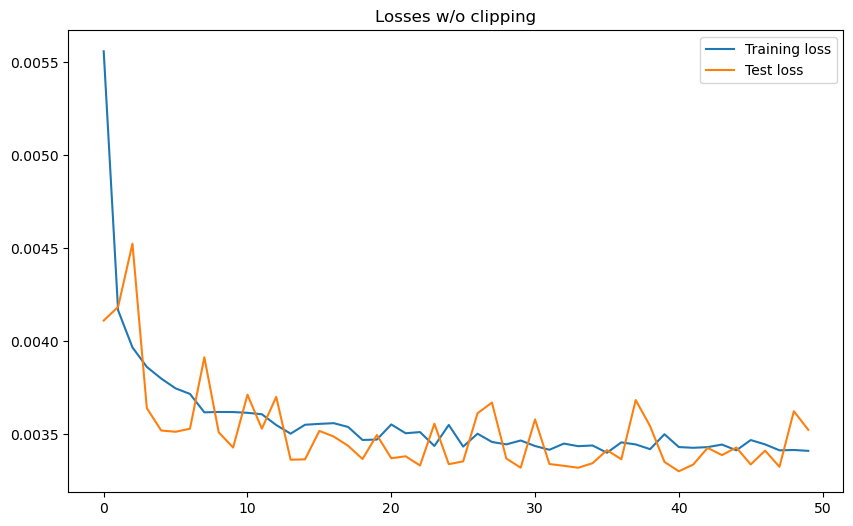

In [6]:
%matplotlib inline

plt.figure(figsize=(10, 6))
plt.title('Losses w/o clipping')
plt.plot(tda_loss, label='Training loss')
plt.plot(tda_test_loss, label='Test loss')
plt.legend()
plt.show()


In [7]:
scaling_factor = 0.7
learning_rate = 0.0035
model = Network(input_size, hidden_size, input_size,
                time_window, scaling_factor, max_value=1.0, op=torch.mean)
# criterion for time series 
criterion = nn.MSELoss()
# Use a smaller learning rate
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

num_epochs = 50
tda_clip_loss, tda_test_clip_loss = train(
    model, criterion, optimizer, train_loader, test_loader, num_epochs)


/Users/andrei/miniforge3/envs/rdl/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([128, 1])) that is different to the input size (torch.Size([128, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/andrei/miniforge3/envs/rdl/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([103, 1])) that is different to the input size (torch.Size([103, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/andrei/miniforge3/envs/rdl/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([122, 1])) that is different to the input size (torch.Size([122, 128])). This will likely lead to incorrect results

Epoch [50/50], Test Loss: 0.0084


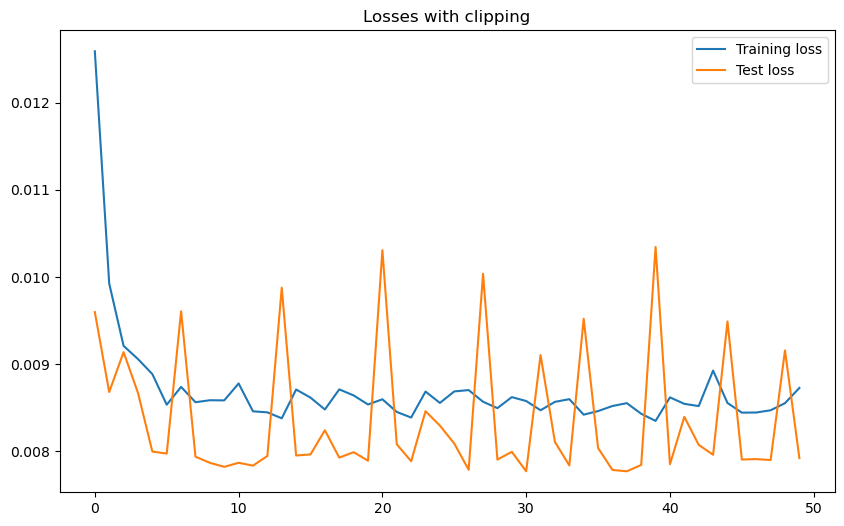

In [8]:
%matplotlib inline

plt.figure(figsize=(10, 6))
plt.title('Losses with clipping')
plt.plot(tda_clip_loss, label='Training loss')
plt.plot(tda_test_clip_loss, label='Test loss')
plt.legend()
plt.show()


In [10]:
batch_x, batch_y = next(iter(test_loader))
batch_x.shape

torch.Size([128, 60, 7])

In [20]:
output = model(batch_x[:1,:,:]).detach().numpy()
batch_y.shape

torch.Size([128, 1])